In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (accuracy_score, classification_report,
                           confusion_matrix, roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
# Set random seeds for reproducibility
torch.manual_seed(52)
np.random.seed(52)

In [8]:
# 1. Dataset Generation
X, y = make_classification(n_samples=2000, n_features=20, n_informative=15,
                          n_redundant=2, n_classes=5, n_clusters_per_class=1,
                          random_state=42)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data (stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [9]:
# 2. Neural Network Implementation
class ThreeLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes):
        super(ThreeLayerNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.BatchNorm1d(hidden_dims[2]),
            nn.ReLU()
        )
        self.output = nn.Linear(hidden_dims[2], num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return self.output(out)

In [10]:
# Initialize model
input_dim = X_train.shape[1]
hidden_dims = [256, 128, 64]  # Three hidden layers
num_classes = 5
model = ThreeLayerNN(input_dim, hidden_dims, num_classes)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ThreeLayerNN(
  (layer1): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (output): Linear(in_features=64, out_features=5, bias=True)
)

In [15]:
#Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)

In [14]:
#Training parameters
epochs = 400
batch_size = 64
patience = 10
best_val_acc = 0
patience_counter = 0

In [17]:
from torch.utils.data import TensorDataset, DataLoader
import torch

# Convert X_train and y_train to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32) # Assuming X_train is float data
y_train_tensor = torch.tensor(y_train, dtype=torch.long)    # Assuming y_train is integer labels

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [37]:
# 4. Training Loop
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Convert X_test and y_test to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

for epoch in range(1, epochs+1):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        # Corrected indentation for this line
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    # Calculate training metrics - Moved inside the epoch loop
    train_loss = epoch_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    with torch.no_grad():
        # Use X_test_tensor here
        val_outputs = model(X_test_tensor)
        # Use y_test_tensor here
        val_loss = criterion(val_outputs, y_test_tensor)
        _, val_preds = torch.max(val_outputs, 1)
        val_acc = accuracy_score(y_test, val_preds.cpu().numpy())

        val_losses.append(val_loss.item())
        val_accs.append(val_acc)

        # Update learning rate scheduler
        scheduler.step(val_acc)

         # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch [{epoch}/{epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss.item():.4f}")
        print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}\n")

Early stopping at epoch 1


In [39]:
# Load best model
model.load_state_dict(best_model)

<All keys matched successfully>


Classification Report:
              precision    recall  f1-score   support

           0     0.9868    0.9375    0.9615        80
           1     0.9506    0.9747    0.9625        79
           2     0.9875    0.9875    0.9875        80
           3     0.9756    0.9877    0.9816        81
           4     0.9506    0.9625    0.9565        80

    accuracy                         0.9700       400
   macro avg     0.9702    0.9700    0.9699       400
weighted avg     0.9703    0.9700    0.9700       400



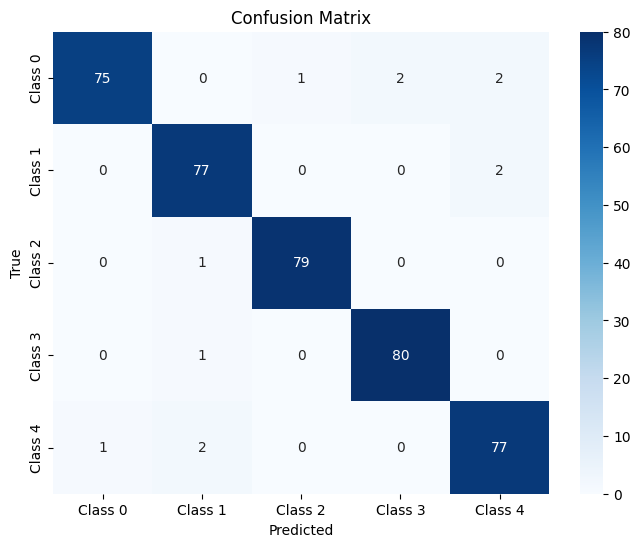

In [42]:
# 5. Evaluation
model.eval()
with torch.no_grad():
    # Convert X_test to a PyTorch tensor and move it to the device
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_pred = torch.argmax(model(X_test_tensor), dim=1).cpu()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Class {i}" for i in range(5)],
            yticklabels=[f"Class {i}" for i in range(5)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

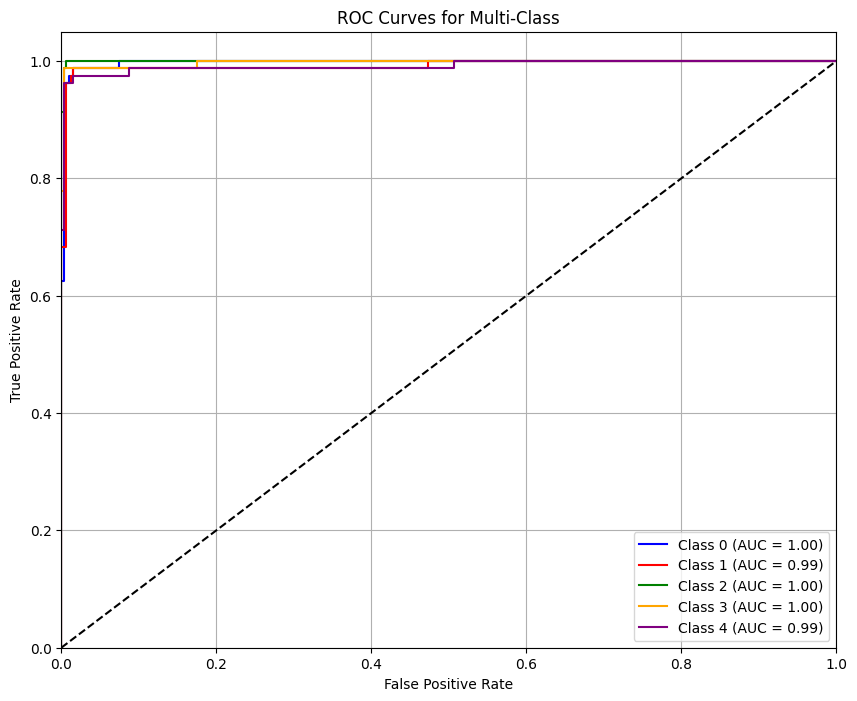

In [48]:
# ROC Curves
y_test_onehot = OneHotEncoder(sparse_output=False).fit_transform(y_test.reshape(-1, 1))
# Convert X_test to a PyTorch tensor before calling .to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_scores = torch.softmax(model(X_test_tensor), dim=1).cpu().detach().numpy()

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class')
plt.legend(loc="lower right")
plt.grid()
plt.show()

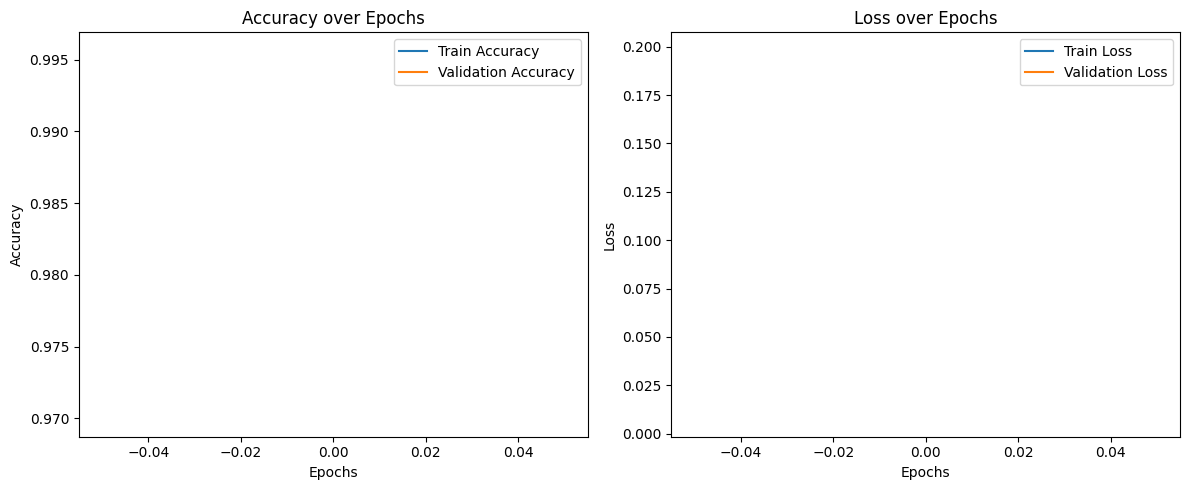

In [49]:
# Training Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()